# Assignment 3 (Lesson 11)

In [1]:
import numpy
import math
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline
%run ./definitions.ipynb

import os
import numpy
from scipy import integrate, linalg

## Part 1: Williams' test case

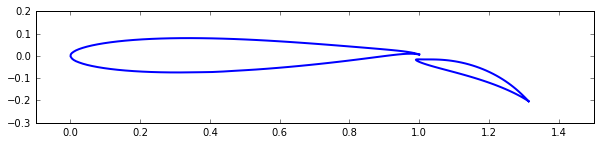

In [2]:
# some knowns
N = 100               # each
Nx, Ny = 100, 100     # just for consistency
steps = 1

# some initializing
panels = numpy.empty((steps,2*N), dtype=object)
mainpanels = numpy.empty((steps,N), dtype=object)
flappanels = numpy.empty((steps,N), dtype=object)
xf = numpy.empty((steps,2*N), dtype=object)
yf = numpy.empty((steps,2*N), dtype=object)
u, v = numpy.empty((steps, Nx, Ny), dtype=float), \
        numpy.empty((steps, Nx, Ny), dtype=float)
cp = numpy.empty((steps, Nx, Ny), dtype=float)
# accuracy = numpy.empty(steps, dtype=float)
lift, drag = numpy.empty(steps, dtype=float),numpy.empty(steps, dtype=float)
cl = numpy.empty(steps, dtype=float)
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

# picking up some x and y values
mainfoilpath = os.path.join('resources','MainFoil_N=100.csv')
with open (mainfoilpath, 'r') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoilpath = os.path.join('resources','FlapFoil_N=100.csv')
with open (flapfoilpath, 'r') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
# picking my friends 
xa, xz, ya, yz = -0.1, 1.5, -0.3, 0.2
l_total = (numpy.max(xmain)-numpy.min(xmain)) + (numpy.max(xflap)-numpy.min(xflap))

# plot em
pyplot.figure(figsize=(10,2))
pyplot.plot(xmain, ymain, xflap, yflap,  color='b', linestyle='-', linewidth=2)
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [3]:
mainpanels = cam_define_panels(xmain,ymain,len(xmain)-1)
flappanels = cam_define_panels(xflap,yflap,len(xflap)-1)
panels = numpy.concatenate((mainpanels, flappanels), axis=0)

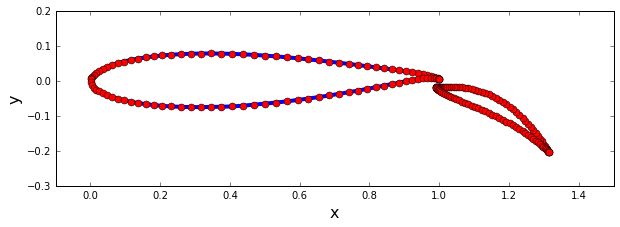

In [5]:
# and plot this
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xmain, ymain, xflap, yflap, color='b', linestyle='-', linewidth=4)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=0, marker='o', markersize=7, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [6]:
# Get our scaling right for the plots
val_x, val_y = 2.0, 4.0
x_min, x_max = numpy.min( [panel.xa for panel in mainpanels] ), numpy.max( [panel.xa for panel in flappanels] )
y_min, y_max = numpy.min( [panel.ya for panel in flappanels] ), numpy.max( [panel.ya for panel in mainpanels] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

# Create our meshgrid for the plots
x, y, X, Y = makemesh(N, x_start, x_end, y_start, y_end)

In [7]:
A, At = build_matrix(panels)
b = build_rhs(panels, freestream)
variables = numpy.linalg.solve(A,b)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

In [8]:
for j, panel in enumerate(panels):
    panel.sigma = variables[j]
        
gamma = variables[-2:]
get_tangential_velocity(panels, freestream, gamma, At)
get_pressure_coefficient(panels, freestream)

u, v = get_velocity_field(panels, freestream, X, Y)
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2
panel_main, panel_flap = panels[0:N], panels[N:]

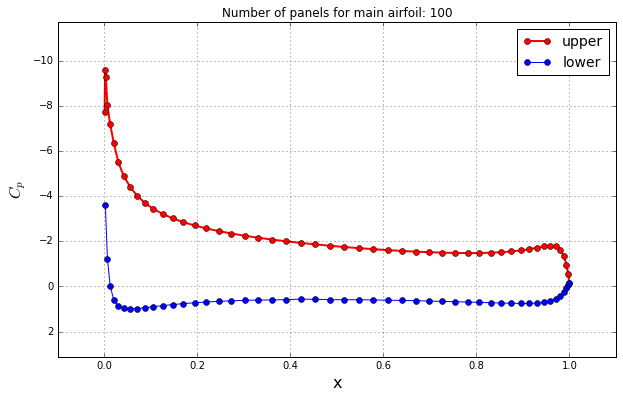

In [9]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in panel_main] ), numpy.max( [panel.xa for panel in panel_main] )
cp_min, cp_max = numpy.min( [panel.cp for panel in panel_main] ), numpy.max( [panel.cp for panel in panel_main] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'upper'], 
         [panel.cp for panel in panel_main if panel.loc == 'upper'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'lower'], 
         [panel.cp for panel in panel_main if panel.loc == 'lower'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for main airfoil: %d' % N);

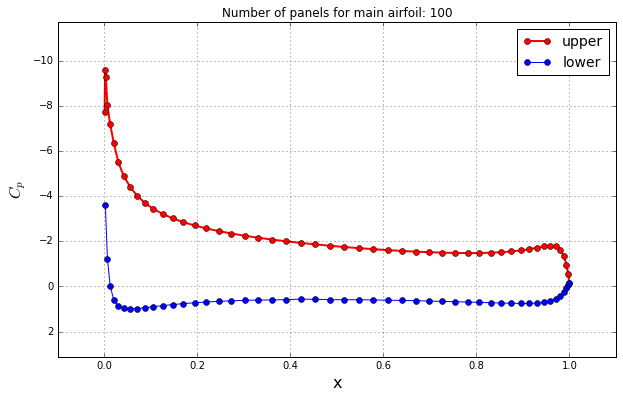

In [10]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in mainpanels]), numpy.max( [panel.xa for panel in mainpanels] )
cp_min, cp_max = numpy.min( [panel.cp for panel in mainpanels] ), numpy.max( [panel.cp for panel in mainpanels] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in mainpanels if panel.loc == 'upper'],
            [panel.cp for panel in mainpanels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in mainpanels if panel.loc == 'lower'],
            [panel.cp for panel in mainpanels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for main airfoil: %d' % N);

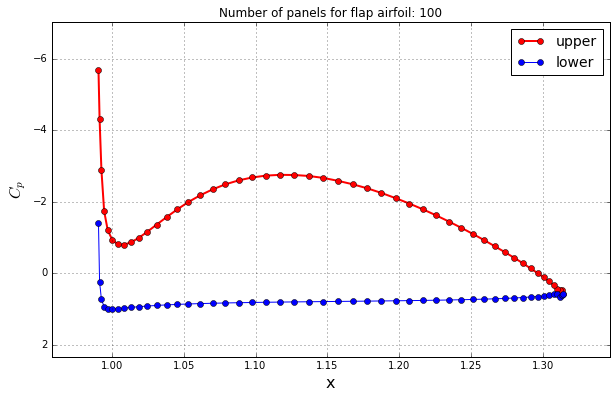

In [11]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in flappanels]), numpy.max( [panel.xa for panel in flappanels] )
cp_min, cp_max = numpy.min( [panel.cp for panel in flappanels] ), numpy.max( [panel.cp for panel in flappanels] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'upper'],
            [panel.cp for panel in flappanels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'lower'],
            [panel.cp for panel in flappanels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for flap airfoil: %d' % N);

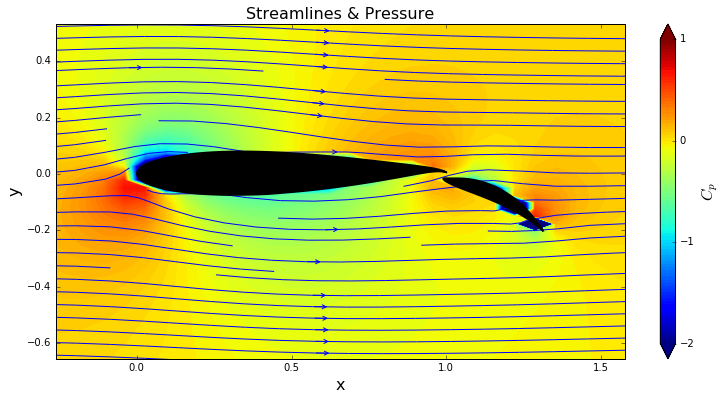

In [12]:
val_x, val_y = 0.2, 1.6
x_min, x_max = numpy.min( [panel.xa for panel in panels] ), numpy.max( [panel.xa for panel in panels] )
y_min, y_max = numpy.min( [panel.ya for panel in panels] ), numpy.max( [panel.ya for panel in panels] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

fig = pyplot.figure(figsize=(12.75, 6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines & Pressure', fontsize=16)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])

pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panel_main], 
         [panel.yc for panel in panel_main], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panel.xc for panel in panel_flap], 
         [panel.yc for panel in panel_flap], 
         color='k', linestyle='solid', linewidth=2, zorder=2);

In [13]:
# Question 1
q1 = mainpanels[2].cp
print('Cp for 3rd panel on main: ', str(q1))

# Question 2
q2 = flappanels[9].cp
print('Cp for 10th panel on main: ', str(q2))

Cp for 3rd panel on main:  -0.955701172981
Cp for 10th panel on main:  -0.279918398369


In [14]:
panels = numpy.concatenate((panel_main, panel_flap), axis=0)

lift = 0
drag = 0

accuracy = sum([panel.sigma*panel.length for panel in panel_main])
accuracy += sum([panel.sigma*panel.length for panel in panel_flap])
    
for panel in panels:
    lift -= panel.cp * panel.length * math.sin(panel.beta)
    drag += panel.cp * panel.length * math.cos(panel.beta) 
    
# Question 3
print('Q3')
print('Total value of lift: ', lift)

# Question 4
print('Q4')
print('Total value of drag: ', drag)

# Question 5  
print('Q5')  
print('Sum (N=' + str(N) + '): ' + str(accuracy))
print('Sum (N=100): -0.00174836054324')
accuracy1 = -0.00174836054324
percent = (accuracy1 - accuracy) / accuracy
print('Change in: ', percent)

Q3
Total value of lift:  3.69771447686
Q4
Total value of drag:  0.0107914032459
Q5
Sum (N=100): -0.00174836054324
Sum (N=100): -0.00174836054324
Change in:  -1.71811846858e-12


# N = 200

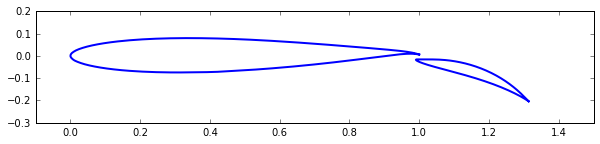

In [16]:
# some knowns
N = 200               # each
Nx, Ny = 100, 100     # just for consistency
steps = 1

# some initializing
panels = numpy.empty((steps,2*N), dtype=object)
mainpanels = numpy.empty((steps,N), dtype=object)
flappanels = numpy.empty((steps,N), dtype=object)
xf = numpy.empty((steps,2*N), dtype=object)
yf = numpy.empty((steps,2*N), dtype=object)
u, v = numpy.empty((steps, Nx, Ny), dtype=float), \
        numpy.empty((steps, Nx, Ny), dtype=float)
cp = numpy.empty((steps, Nx, Ny), dtype=float)
# accuracy = numpy.empty(steps, dtype=float)
lift, drag = numpy.empty(steps, dtype=float),numpy.empty(steps, dtype=float)
cl = numpy.empty(steps, dtype=float)
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

# picking up some x and y values
mainfoilpath = os.path.join('resources','MainFoil_N=200.csv')
with open (mainfoilpath, 'r') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoilpath = os.path.join('resources','FlapFoil_N=200.csv')
with open (flapfoilpath, 'r') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
# picking my friends 
xa, xz, ya, yz = -0.1, 1.5, -0.3, 0.2
l_total = (numpy.max(xmain)-numpy.min(xmain)) + (numpy.max(xflap)-numpy.min(xflap))

# plot em
pyplot.figure(figsize=(10,2))
pyplot.plot(xmain, ymain, xflap, yflap,  color='b', linestyle='-', linewidth=2)
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [17]:
mainpanels = cam_define_panels(xmain,ymain,len(xmain)-1)
flappanels = cam_define_panels(xflap,yflap,len(xflap)-1)
panels = numpy.concatenate((mainpanels, flappanels), axis=0)

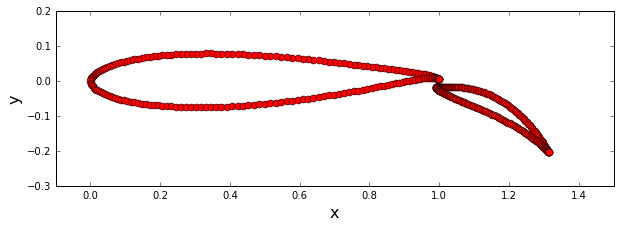

In [18]:
# and plot this
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xmain, ymain, xflap, yflap, color='b', linestyle='-', linewidth=4)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=0, marker='o', markersize=7, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [19]:
# Get our scaling right for the plots
val_x, val_y = 2.0, 4.0
x_min, x_max = numpy.min( [panel.xa for panel in mainpanels] ), numpy.max( [panel.xa for panel in flappanels] )
y_min, y_max = numpy.min( [panel.ya for panel in flappanels] ), numpy.max( [panel.ya for panel in mainpanels] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

# Create our meshgrid for the plots
# x, y, X, Y = makemesh(N, x_start, x_end, y_start, y_end)

In [20]:
A, At = build_matrix(panels)
b = build_rhs(panels, freestream)
variables = numpy.linalg.solve(A,b)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

In [21]:
for j, panel in enumerate(panels):
    panel.sigma = variables[j]

In [22]:
gamma = variables[-2:]
get_tangential_velocity(panels, freestream, gamma, At)
get_pressure_coefficient(panels, freestream)

In [23]:
u, v = get_velocity_field(panels, freestream, X, Y)
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2
panel_main, panel_flap = panels[0:N], panels[N:]

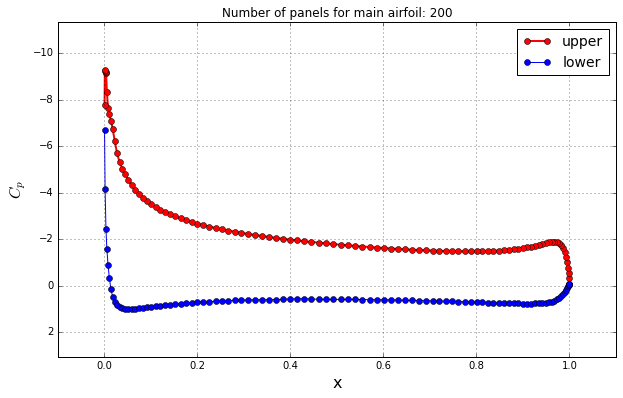

In [24]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in panel_main] ), numpy.max( [panel.xa for panel in panel_main] )
cp_min, cp_max = numpy.min( [panel.cp for panel in panel_main] ), numpy.max( [panel.cp for panel in panel_main] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'upper'], 
         [panel.cp for panel in panel_main if panel.loc == 'upper'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'lower'], 
         [panel.cp for panel in panel_main if panel.loc == 'lower'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for main airfoil: %d' % N);

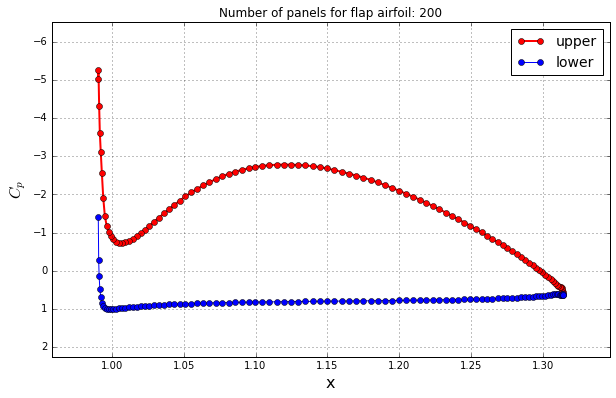

In [25]:
val_x, val_y = 0.10, 0.20
x_min, x_max = numpy.min( [panel.xa for panel in flappanels]), numpy.max( [panel.xa for panel in flappanels] )
cp_min, cp_max = numpy.min( [panel.cp for panel in flappanels] ), numpy.max( [panel.cp for panel in flappanels] )
x_start, x_end = x_min - val_x * (x_max-x_min), x_max + val_x * (x_max-x_min)
y_start, y_end = cp_min - val_y * (cp_max-cp_min), cp_max + val_y * (cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'upper'],
            [panel.cp for panel in flappanels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'lower'],
            [panel.cp for panel in flappanels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels for flap airfoil: %d' % N);

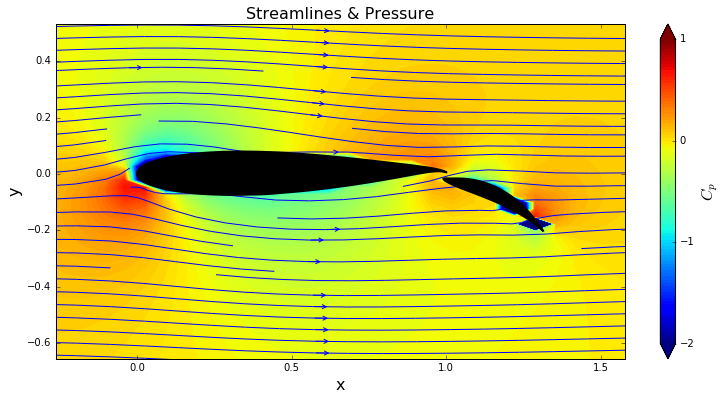

In [26]:
val_x, val_y = 0.2, 1.6
x_min, x_max = numpy.min( [panel.xa for panel in panels] ), numpy.max( [panel.xa for panel in panels] )
y_min, y_max = numpy.min( [panel.ya for panel in panels] ), numpy.max( [panel.ya for panel in panels] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

fig = pyplot.figure(figsize=(12.75, 6))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines & Pressure', fontsize=16)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])

pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panel_main], 
         [panel.yc for panel in panel_main], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.fill([panel.xc for panel in panel_flap], 
         [panel.yc for panel in panel_flap], 
         color='k', linestyle='solid', linewidth=2, zorder=2);

In [31]:
panels = numpy.concatenate((panel_main, panel_flap), axis=0)

lift = 0
drag = 0

accuracy = sum([panel.sigma*panel.length for panel in panel_main])
accuracy += sum([panel.sigma*panel.length for panel in panel_flap])
    
for panel in panels:
    lift -= panel.cp * panel.length * math.sin(panel.beta)
    drag += panel.cp * panel.length * math.cos(panel.beta) 
    
# Question 5  
print('Q5')  
print('Lift value, N=100: 3.69771447686')
print('Accuracy, N=100: -0.00174836054324')
print('Lift value, N=200:', str(lift))
print('Accuracy, N=200:', str(accuracy))

lift1 = 3.69771447686
sum1 = -0.00174836054324

percentlift = 100 * (lift1 - lift) / lift1
percentsum = 100 * (sum1 - accuracy) / sum1

print('% Change in lift value: ', percentlift)
print('% Change in lift value: ', percentsum)

Q5
Lift value, N=100: 3.69771447686
Accuracy, N=100: -0.00174836054324
Lift value, N=200: 3.71843390868
Accuracy, N=200: -0.000826784259805
% Change in lift value:  -0.56033076515
% Change in lift value:  52.7108831756
